In [15]:
## Since this is a more cleaned up work in progress, I'll use a jupyter notebook to make this a little easier

## Imports
from orbitPropagator import (
    twoBodyProp,
    cartesianToOrbitalElements,
    orbitalElementsToCartesian,
)
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from orbitPlotter import plotter
import keras_tuner as kt

In [16]:
## Here we will initialize our datasets

# Important Constants 
G = 6.67 * 10**-11  # N*m^2/kg^2
m_earth = 5.972 * 10**24  # kg
altitude_test = 8 * 10**6  # m
altitude_train = 5 * 10**6  # m
planet_radius = 6.371 * 10**6  # Earth radius meters

# First I'll create a suitable list of orbits using Keplerian orbital elements
orbits = 200
orbital_set_initial_conditions = np.zeros((orbits, 6))

## Using random I will populate each of these with acceptable parameters
## Rules - semimajor axis (a) must be in the range of 2,000 km to ~36,000 km
##      - inclination must be between 0 and pi
##      - eccentricity must be between 0 and 1
##      - RAAN is 0 and 2pi
##      - periapsis is 0 and 2pi
##      - true anomaly is 0 and 2pi
semi = np.linspace(2000000 + planet_radius, 36000000 + planet_radius, orbits)
for i in range(orbits):
    for j in range(6):
        if j == 0:
            #Everything I've done is in meters
            semimajor = np.random.randint(low=2000000 + planet_radius, high=36000000 + planet_radius)
            orbital_set_initial_conditions[i, j] = semi[i]
        
        if j == 1:
            ## I'll do eccentricities between 0 and 0.1
            e = np.random.rand() * 0.1  # random may not be so good lol (unless your sample size is large enough, lets make it larger)
            orbital_set_initial_conditions[i, j] = 0.001
        
        if 5 > j >= 2 :
            inclination = np.random.rand() * np.pi
            orbital_set_initial_conditions[i, j] = 0
        if j == 5:
            random = 2 * np.pi * np.random.rand()
            orbital_set_initial_conditions[i, j] = 0


In [17]:
## Now that we have our numerically well conditioned orbits between LEO and GEO, we can propagate them
## for now all but the last will be for training

## We will have to convert each back to cartesian, propagate, and then back to orbital elements with the associated time step
propagated_orbits = []
cartesian_propagated_array = []
for i in range(orbits):
    cartesian_orbit = orbitalElementsToCartesian(orbital_set_initial_conditions[i], m_earth)
    cartesian_propagated = twoBodyProp(
        cartesian_orbit[0], 
        cartesian_orbit[1],
        cartesian_orbit[2],
        cartesian_orbit[3],
        cartesian_orbit[4],
        cartesian_orbit[5],
        export_time=True,
        time_step=100
        )
    for j in range(len(cartesian_propagated)):
        # Back to orbital elements
        cartesian_propagated[j] = cartesianToOrbitalElements(cartesian_propagated[j], m_earth, isTime=True)
    
    propagated_orbits.append(cartesian_propagated)
# Now what we have is a list of numpy arrays containing the orbital elements for each of the defined orbits including time steps 

/Users/loggy/MLDS/MLDSOnBoarding/OrbitPropagation/orbitPropagator.py:157: RuntimeWarning: invalid value encountered in scalar divide
  RA_ascending_node = np.arccos(n[0] / np.linalg.norm(n))
/Users/loggy/MLDS/MLDSOnBoarding/OrbitPropagation/orbitPropagator.py:167: RuntimeWarning: invalid value encountered in scalar divide
  np.dot(n, e_vector) / (np.linalg.norm(n) * np.linalg.norm(e_vector))


In [18]:
## Now we need to split these orbits into training and test sets
## Create the training sets without true anomaly
train_features = [np.delete(arr, 5, axis=1) for arr in propagated_orbits[:int(orbits-(orbits*.2))]]
train_labels = [arr[:, 5] for arr in propagated_orbits[:int(orbits-(orbits*.2))]]

test_features = [np.delete(arr, 5, axis=1) for arr in propagated_orbits[int(orbits-(orbits*.2)):]]
test_labels = [arr[:, 5] for arr in propagated_orbits[int(orbits-(orbits*.2)):]]

test_features_single = np.delete(propagated_orbits[orbits-1], 5, axis=1)
test_labels_single = propagated_orbits[orbits-1][:, 5]


In [19]:
## Now we normalize it
## this is where the mishapen nature of train_features has caught up with me
## Up until now it was good because it kept orbits separated but now I really should just squash it together
train_features = np.vstack(train_features)
flat_array = np.concatenate(train_labels)
# Reshape to (number of values, 1)
train_labels = flat_array.reshape(-1, 1)
test_features = np.vstack(test_features)
flat_array2 = np.concatenate(test_labels)
test_labels = np.vstack(flat_array2)

test_features_single = np.vstack(test_features_single)
test_labels_single = np.vstack(test_labels_single)

## Now everything is happy
train_features_normalizer = layers.Normalization(axis=-1)
train_features_normalizer.adapt(train_features)

In [20]:
# Now we create the model
# # Build the model using keras.Sequential
# def build_and_compile_model(norm):
#     model = keras.Sequential(
#         [
#             # Time normalization layer
#             norm, ## input layer has 6 features
#             layers.Dense(50, activation="relu"),
#             layers.Dense(6, activation="relu"),
#             layers.Dense(1),
#         ]
#     )
#     model.compile(
#         loss="mean_absolute_error",
#         optimizer=tf.keras.optimizers.Adam(0.01),
#         metrics=["accuracy"],
#     )
#     return model

# dnn_train_features_model = build_and_compile_model(train_features_normalizer)

def build_model(hp):
    model = keras.Sequential([
        train_features_normalizer,  # Keep the input normalization layer
        layers.Dense(
            units=hp.Int('units', min_value=20, max_value=100, step=16), 
            activation=hp.Choice('activation', values=['relu', 'tanh'])
        ),
        layers.Dense(6, activation="relu"),
        layers.Dense(1, activation='linear'),
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])
        ),
        loss=keras.losses.Huber(),
        metrics=['mae']
    )
    return model


In [21]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # Number of hyperparameter settings to try
    executions_per_trial=2,  # Number of models to train per trial
)

tuner.search_space_summary()

# Run the hyperparameter search
tuner.search(train_features, train_labels, 
             epochs=30, 
             validation_data=(test_features, test_labels), 
             batch_size=32)

Reloading Tuner from ./untitled_project/tuner0.json
Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 100, 'step': 16, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.0001], 'ordered': True}


In [22]:
best_model = tuner.get_best_models(num_models=1)[0]

/Users/loggy/MLDS/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [23]:
history = best_model.fit(
    train_features,
    train_labels,
    epochs=100,  # Continue training for additional epochs
    validation_data=(test_features, test_labels),
    batch_size=32  # You can adjust the batch size if needed
)

Epoch 1/100
1709/1709 ━━━━━━━━━━━━━━━━━━━━ 1s 507us/step - loss: 0.1523 - mae: 0.3362 - val_loss: 0.0353 - val_mae: 0.1712
Epoch 2/100
1709/1709 ━━━━━━━━━━━━━━━━━━━━ 1s 466us/step - loss: 0.0291 - mae: 0.0875 - val_loss: 0.0272 - val_mae: 0.1372
Epoch 3/100
1709/1709 ━━━━━━━━━━━━━━━━━━━━ 1s 470us/step - loss: 0.0259 - mae: 0.0669 - val_loss: 0.0252 - val_mae: 0.1265
Epoch 4/100
1709/1709 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - loss: 0.0264 - mae: 0.0674 - val_loss: 0.0259 - val_mae: 0.1287
Epoch 5/100
1709/1709 ━━━━━━━━━━━━━━━━━━━━ 1s 467us/step - loss: 0.0263 - mae: 0.0638 - val_loss: 0.0240 - val_mae: 0.1218
Epoch 6/100
1709/1709 ━━━━━━━━━━━━━━━━━━━━ 1s 466us/step - loss: 0.0275 - mae: 0.0650 - val_loss: 0.0232 - val_mae: 0.1193
Epoch 7/100
1709/1709 ━━━━━━━━━━━━━━━━━━━━ 1s 466us/step - loss: 0.0252 - mae: 0.0615 - val_loss: 0.0225 - val_mae: 0.1116
Epoch 8/100
1709/1709 ━━━━━━━━━━━━━━━━━━━━ 1s 461us/step - loss: 0.0257 - mae: 0.0608 - val_loss: 0.0224 - val_mae: 0.1149
Epoch 9/100
1709

In [24]:
## Now we can train the model
# In a typical use case we can just use model.fit
# history = dnn_train_features_model.fit(
#     train_features,
#     train_labels,
#     validation_split=0.2,
#     verbose=1,
#     epochs=20 * 10**1,
# )

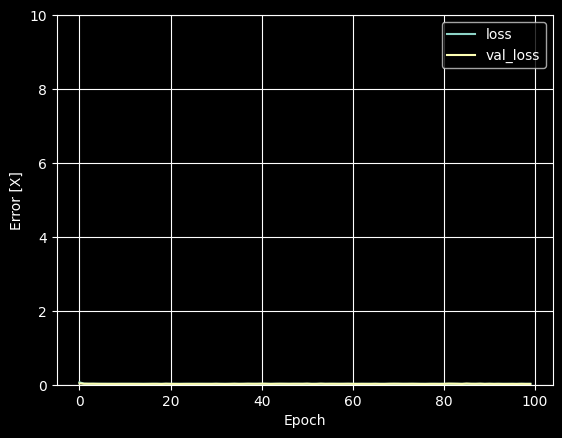

In [25]:
## Check the loss
# Plotting the loss
def plot_loss(history):
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.ylim([0, 10])
    plt.xlabel("Epoch")
    plt.ylabel("Error [X]")
    plt.legend()
    plt.grid(True)


plot_loss(history)
plt.show()

In [26]:
##See some results

test_results = best_model.evaluate(test_features, test_labels, verbose=1)

964/964 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step - loss: 0.0151 - mae: 0.0737


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step


/var/folders/2k/r8_xjd912zb94q_bg1gps95h0000gn/T/ipykernel_52921/2223613422.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_prediction_array_orbitalE[i, j] = test_predictions[i]
/var/folders/2k/r8_xjd912zb94q_bg1gps95h0000gn/T/ipykernel_52921/2223613422.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_features_array_orbitalE[i, j] = test_labels_single[i]


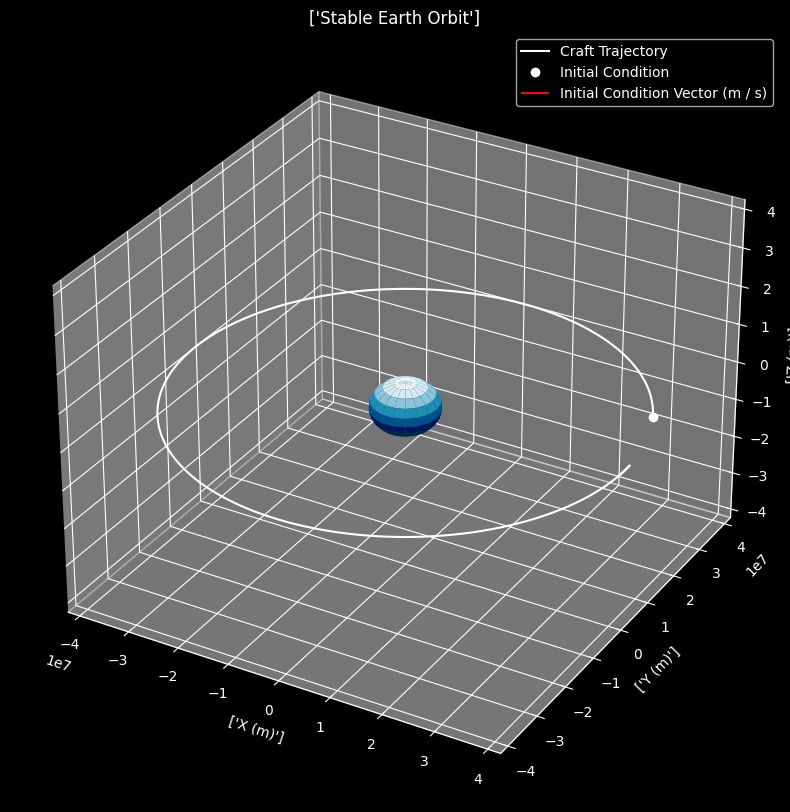

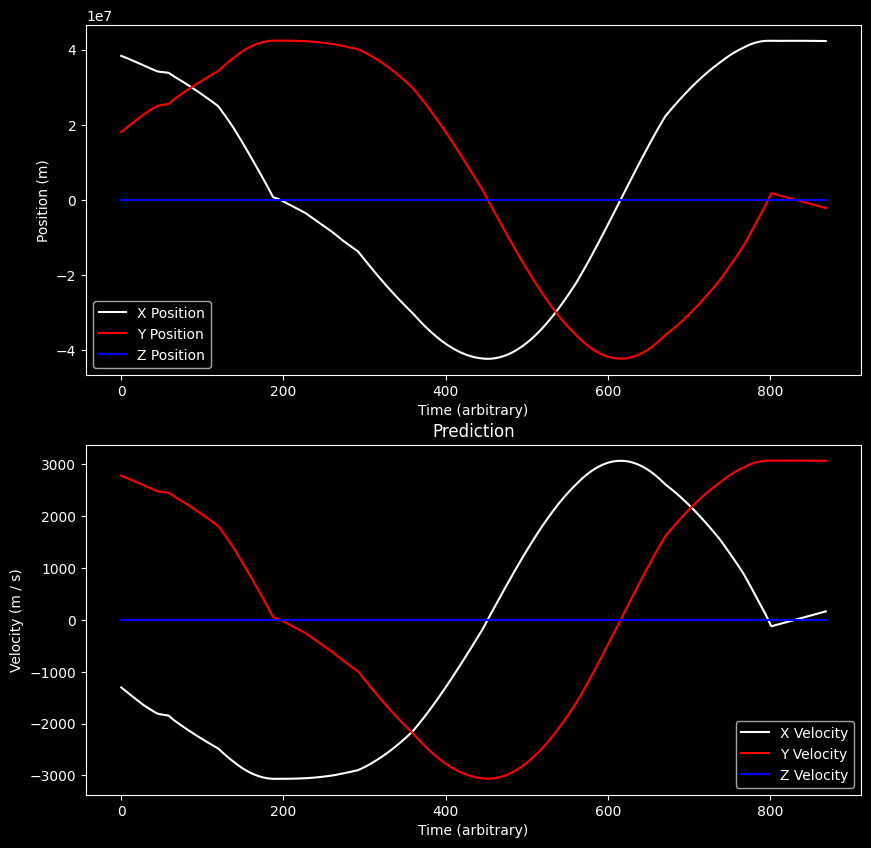

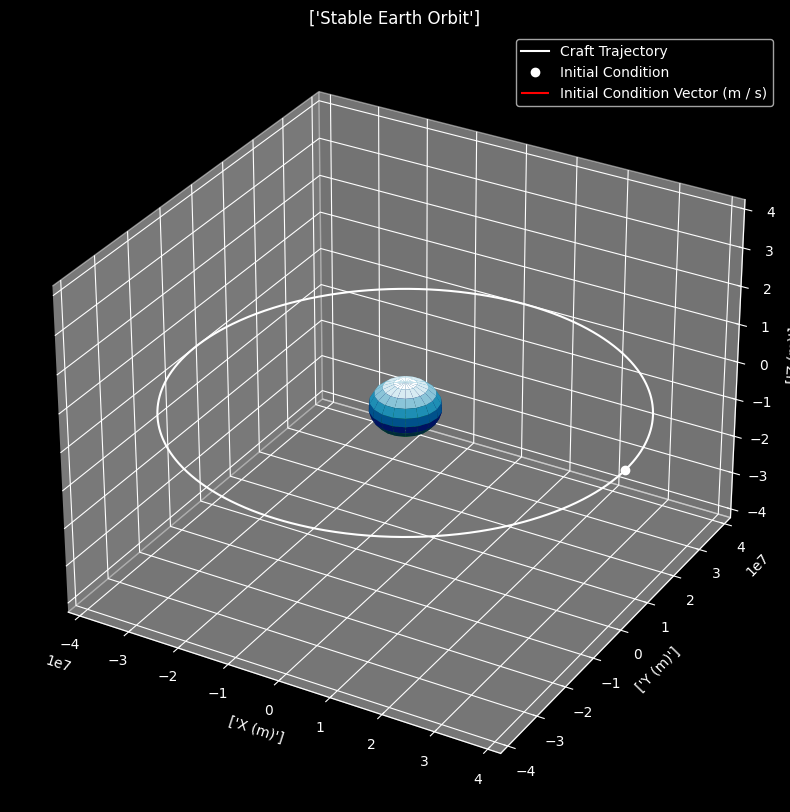

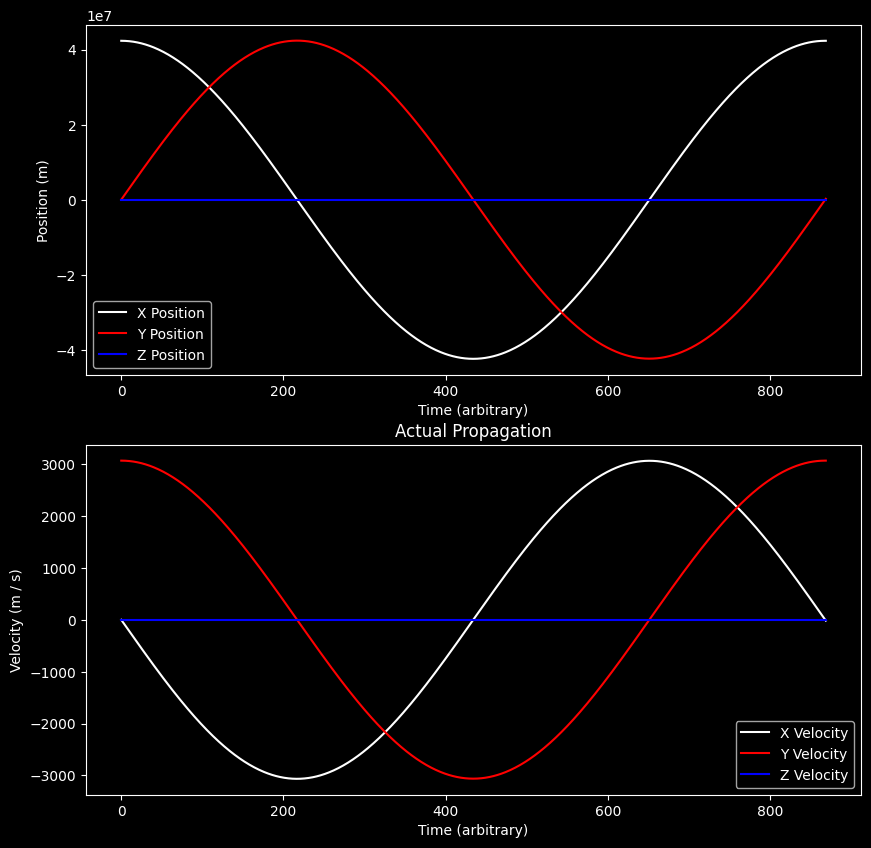

In [27]:
test_predictions = best_model.predict(test_features_single)
test_prediction_array_orbitalE = np.zeros((len(test_predictions), 6))
test_features_array_orbitalE = np.zeros((len(test_predictions), 6))
# print(test_predictions)
for i in range(len(test_predictions)):
    for j in range(6):
        if j < 5:
            test_prediction_array_orbitalE[i, j] = test_features_single[i, j]
            test_features_array_orbitalE[i, j] = test_features_single[i, j]
        else:
            test_prediction_array_orbitalE[i, j] = test_predictions[i]
            test_features_array_orbitalE[i, j] = test_labels_single[i]
## Convert to cartesian
test_prediction_array_cartesian = np.zeros((len(test_predictions), 6))
test_features_array_cartesian = np.zeros((len(test_features_single), 6))
for i in range(len(test_prediction_array_cartesian)):
    element_to_cart = orbitalElementsToCartesian(
        test_prediction_array_orbitalE[i], m_earth
    )
    feature_to_cart = orbitalElementsToCartesian(
        test_features_array_orbitalE[i], m_earth
    )
    for j in range(6):
        test_prediction_array_cartesian[i, j] = element_to_cart[j]
        test_features_array_cartesian[i, j] = feature_to_cart[j]

plotter(test_prediction_array_cartesian)
plt.title('Prediction')
plt.show()

plotter(test_features_array_cartesian)
plt.title('Actual Propagation')
plt.show()


In [28]:
# ## First set of problems - some orbits that are completely fine are showing up really weird

# ## Example 1

# broken_orbit = [1.83789060e+07, 9.08747775e-02, 3.88722922e-01, 4.04577817e+00,
#  2.10304796e+00, 1.00097003e+00]

# broken_cartesian_orbit = orbitalElementsToCartesian(broken_orbit, m_earth)
# broken_orbit_prop = twoBodyProp(
#         broken_cartesian_orbit[0], 
#         broken_cartesian_orbit[1],
#         broken_cartesian_orbit[2],
#         broken_cartesian_orbit[3],
#         broken_cartesian_orbit[4],
#         broken_cartesian_orbit[5],
#         export_time=True,
#         time_step=50
#         )

# plotter(broken_orbit_prop)

# ## Investigation found to be good -  the orbits I am propagating are complete, AND if they look funny in the 3d plot but not in the position/velocity
# ## plots, the 3d plot just looks weird because you cannot rotate it and the planet is plotted over the orbit even if the orbit is not going 
# # through the planet
